In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!nvidia-smi

Tue Nov 25 06:57:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!rm -r indonlu

rm: cannot remove 'indonlu': No such file or directory


In [4]:
!git clone https://github.com/ezaaputra/indonlu.git

Cloning into 'indonlu'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 460 (delta 119), reused 108 (delta 108), pack-reused 312 (from 1)
Receiving objects: 100% (460/460), 4.83 MiB | 6.86 MiB/s, done.
Resolving deltas: 100% (229/229), done.


# 1. Import Library

In [5]:
!pip install emoji
!pip install Sastrawi
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.0 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

# NLP
import nltk
nltk.download('punkt')
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

#Model IndoBERT
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# 2. Import Data

In [8]:
df_path = 'midikriing_reviews.csv'
stopword_path = 'stopword.txt'
kamus_alay_path = 'kamus_alay.csv'

In [9]:
# Import data
df = pd.read_csv(df_path)
df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,91eb52ae-6c78-4f1e-b05d-02164824403b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aplikasinya superr lemotttt!!!!!!!!!!,1,0,25.1,2025-11-22 21:18:42,NaN,NaN,25.1
1,6c1d46b6-9d54-46b4-b0e1-dc5413fb208b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"pesanan tidak diantarkan, sudah dibayar pula, ...",1,0,25.1,2025-11-22 08:30:57,NaN,NaN,25.1
2,c7029cfa-172b-4ddd-a1e0-db12ba63210e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Ease Of Use,5,0,25.1,2025-11-22 01:54:34,NaN,NaN,25.1
3,0a087511-0000-401e-9d50-527af62ad9a1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,berbagi pengalaman penggunaan midi kring vs kl...,1,1,25.1,2025-11-20 14:53:49,NaN,NaN,25.1
4,787f4e80-3d5d-414c-bf27-9efa65f40137,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aplikasi sejauh ini sudah bagus hanya saja lum...,4,0,25.1,2025-11-19 10:44:01,NaN,NaN,25.1
...,...,...,...,...,...,...,...,...,...,...,...
8771,fa4e2539-2191-4c6b-bae5-ab317cf08261,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Sangat mmbantu dalam pembelanjaan,5,0,1.0.1,2021-04-09 10:34:58,NaN,NaN,1.0.1
8772,4d1701bd-d267-4033-ae09-5c0d77e7b6ba,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Mantaap,5,4,1.0.2,2021-04-09 10:34:27,NaN,NaN,1.0.2
8773,c802ddf4-6d71-4ccd-9a64-deae2f05f296,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Bismillah ,",5,1,NaN,2021-04-09 10:30:56,NaN,NaN,NaN
8774,4f75b650-97ad-404c-9276-4f8bd61d70fc,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Belanja di alfamidi lebih mudah pakai aplikasi...,5,0,1.0.1,2021-04-09 10:30:19,NaN,NaN,1.0.1


# 2. Labeling

In [10]:
sentimen = []
for index, row in df.iterrows():
    if row['score'] > 3 :
        sentimen.append("positive")
    elif row['score'] == 3:
        sentimen.append("neutral")
    else:
        sentimen.append("negative")
df['sentiment'] = sentimen
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sentiment
0,91eb52ae-6c78-4f1e-b05d-02164824403b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aplikasinya superr lemotttt!!!!!!!!!!,1,0,25.1,2025-11-22 21:18:42,NaN,NaN,25.1,negative
1,6c1d46b6-9d54-46b4-b0e1-dc5413fb208b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"pesanan tidak diantarkan, sudah dibayar pula, ...",1,0,25.1,2025-11-22 08:30:57,NaN,NaN,25.1,negative
2,c7029cfa-172b-4ddd-a1e0-db12ba63210e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Ease Of Use,5,0,25.1,2025-11-22 01:54:34,NaN,NaN,25.1,positive
3,0a087511-0000-401e-9d50-527af62ad9a1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,berbagi pengalaman penggunaan midi kring vs kl...,1,1,25.1,2025-11-20 14:53:49,NaN,NaN,25.1,negative
4,787f4e80-3d5d-414c-bf27-9efa65f40137,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aplikasi sejauh ini sudah bagus hanya saja lum...,4,0,25.1,2025-11-19 10:44:01,NaN,NaN,25.1,positive


# 4. Exploratory Data Analysis

In [11]:
print(f'shape: {df.shape}')

shape: (8776, 12)


In [12]:
df = df[['content', 'sentiment']]
df

,content,sentiment
0,aplikasinya superr lemotttt!!!!!!!!!!,negative
1,"pesanan tidak diantarkan, sudah dibayar pula, ...",negative
2,Ease Of Use,positive
3,berbagi pengalaman penggunaan midi kring vs kl...,negative
4,aplikasi sejauh ini sudah bagus hanya saja lum...,positive
...,...,...
8771,Sangat mmbantu dalam pembelanjaan,positive
8772,Mantaap,positive
8773,"Bismillah ,",positive
8774,Belanja di alfamidi lebih mudah pakai aplikasi...,positive


## Proporsi Variabel Target

In [13]:
df['sentiment'].value_counts()

,count
sentiment,
positive,6851
negative,1716
neutral,209


In [14]:
# Function to make a donut chart
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%',
           startangle = angle, pctdistance=0.8, explode = explode,
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')
    plt.tight_layout()

In [15]:
# Plot arguments
sizes = df.sentiment.value_counts()
labels = ['Review Positif', 'Review Netral', 'Review Negatif']
colors = ['lightgreen', 'lightskyblue', 'lightcoral']
explode = (0,0,0)

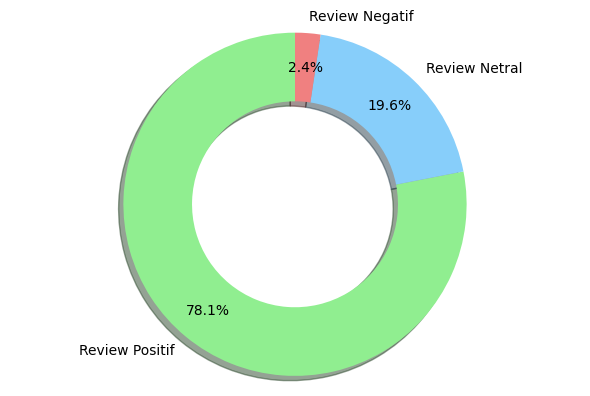

In [16]:
# Create axes
f, ax = plt.subplots(figsize=(6,4))

# plot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)

plt.show()

# 5. PreProcessing

## Preprocessing Tahap 1

In [17]:
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# hapus karakter yang berulang
def repeatcharClean(content):
  for i in range(len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long
      content = content.replace(char,character[i])
      charac_long -= 1
  return content

In [18]:
def clean_review(content):
  # ubah content menjadi huruf kecil
  content = content.lower()
  content = re.sub(r'http\S+',' ', content)
  content = re.sub(r'@\w+',' ', content)
  content = re.sub(r'\s+',' ', content)
  return content

In [19]:
def preprocess_v1(df):
  df_pp = df.copy()
  df_pp.content = df_pp.content.map(clean_review)

  # delete empty row
  df_pp.content.replace('', np.nan, inplace=True)
  df_pp.content.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['content'], inplace=True)
  return df_pp

In [20]:
df_v1 = preprocess_v1(df)

/tmp/ipython-input-3285970941.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pp.content.replace('', np.nan, inplace=True)
/tmp/ipython-input-3285970941.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [21]:
# export to tsv
df_v1.to_csv('df_v1.tsv', sep='\t', header=None, index=False)

## Preprocessing Tahap 2

In [22]:
kamus_alay = pd.read_csv(kamus_alay_path)

normalize_word_dict = {}
for index, row in kamus_alay.iterrows():
    if row[0] not in normalize_word_dict:
        normalize_word_dict[row[0]] = row[1]

/tmp/ipython-input-3314676309.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] not in normalize_word_dict:
/tmp/ipython-input-3314676309.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalize_word_dict[row[0]] = row[1]


In [23]:
def normalize_review(content):
  # tokenize
  list_content = word_tokenize(content)
  # ubah bahasa alay
  list_content = [normalize_word_dict[term] if term in normalize_word_dict else term for term in list_content]
  # gabung kembali kalimat
  content = " ".join(list_content)
  return content

In [24]:
def preprocess_v2(df):
  df_pp = df.copy()
  df_pp.content = df_pp.content.map(normalize_review)

  # delete empty row
  df_pp.content.replace('', np.nan, inplace=True)
  df_pp.content.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['content'], inplace=True)
  return df_pp

In [25]:
# take a while
df_v2  = preprocess_v2(df_v1)

/tmp/ipython-input-1928286488.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pp.content.replace('', np.nan, inplace=True)
/tmp/ipython-input-1928286488.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [26]:
# export to tsv
df_v2.to_csv('df_v2.tsv', sep='\t', header=None, index=False)

In [27]:
def make_corpus(column):

    corpus_list = []

    for content in column:
        cleaned_list = content.split(' ')
        corpus_list.extend(cleaned_list)

    # transform list of words into 1 body of content
    corpus = ' '.join(corpus_list)
    corpus = re.sub('[ ]+',' ',corpus) # replace double whitespace with one

    return corpus

In [28]:
# Takes a while
corpus = make_corpus(df_v2.content)

In [29]:
# counting unique words
corpus_set = set(corpus.split(' '))
print(f'Count of unique words in corpus: {len(corpus_set)}')

Count of unique words in corpus: 7608


In [30]:
# function for freqdist
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples

    # decompose into label and frequency
    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})

    return df

In [31]:
corpus_freq = word_freq(corpus, top=20)

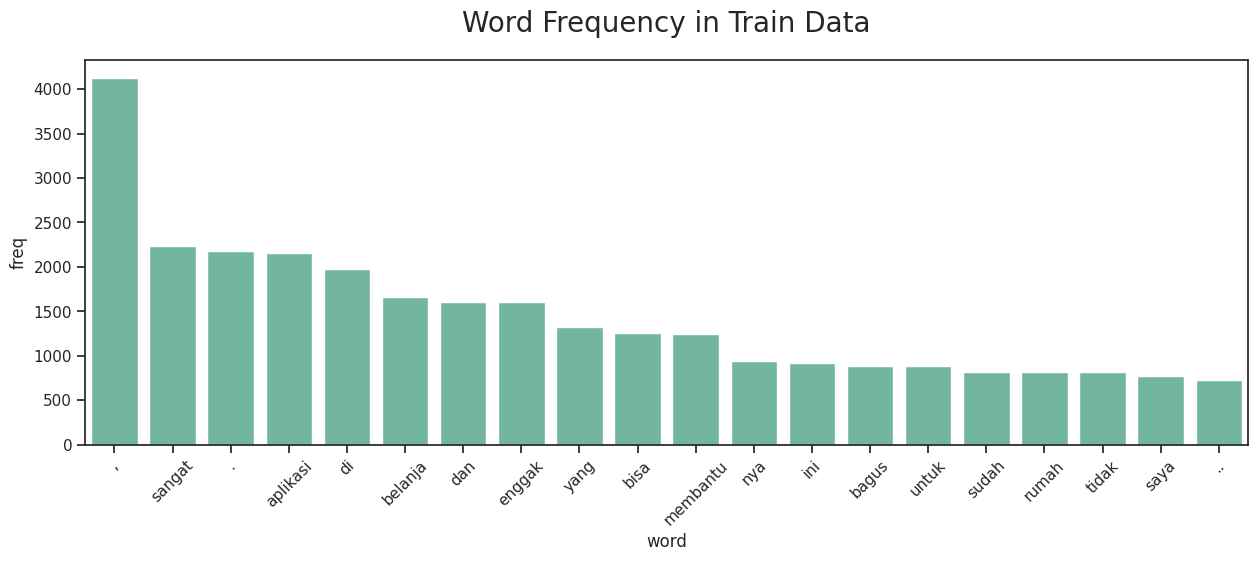

In [32]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))

sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data')
ax1.tick_params(axis='x', rotation=45)

# sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax2)
# ax2.set_title('Word Frequency in Train Data')
# ax2.tick_params(axis='x', rotation=45)

# sns.despine(ax=ax1)
# sns.despine(ax=ax2)
plt.show()

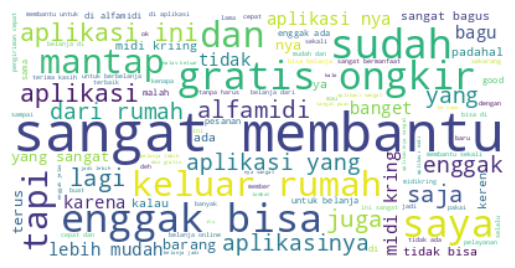

In [33]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 6. Splitting

In [34]:
# train val split
train_set, val_set = train_test_split(df_v2, test_size=0.3, stratify=df_v2.sentiment, random_state=1)
val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set.sentiment, random_state=1)

In [35]:
print(f'Train shape: {train_set.shape}')
print(f'Val shape: {val_set.shape}')
print(f'Test shape: {test_set.shape}')

Train shape: (6143, 2)
Val shape: (1764, 2)
Test shape: (869, 2)


In [36]:
# export to tsv
train_set.to_csv('train_set.tsv', sep='\t', header=None, index=False)
val_set.to_csv('val_set.tsv', sep='\t', header=None, index=False)
test_set.to_csv('test_set.tsv', sep='\t', header=None, index=False)

# 7. Handling Imbalace

In [37]:
LABEL_ORDER = ["positive", "neutral", "negative"]

train_set['sentiment'] = train_set['sentiment'].str.lower()
train_set['sentiment'] = train_set['sentiment'].map({
    "positif": "positive",
    "positive": "positive",
    "negatif": "negative",
    "negative": "negative",
    "netral": "neutral",
    "neutral": "neutral"
})

In [38]:
print("Distribusi Kelas sebelum Oversampling:")
class_counts = train_set['sentiment'].value_counts()
print(class_counts)

Distribusi Kelas sebelum Oversampling:
sentiment
positive    4796
negative    1201
neutral      146
Name: count, dtype: int64


In [39]:
target_size = int(class_counts.mean())   # rata-rata jumlah kelas

In [40]:
# Inisialisasi list untuk menampung DataFrame yang sudah diseimbangkan
df_list = []

# Iterasi dan Lakukan Random Oversampling
for label in LABEL_ORDER:
    df_kelas = train_set[train_set['sentiment'] == label]
    jumlah_kelas = len(df_kelas)

    if jumlah_kelas >= target_size:
        # kelas sudah cukup besar → tidak perlu oversampling
        df_list.append(df_kelas)
    else:
        # oversample sampai target yang aman (tidak sampai mayoritas)
        df_oversampled = df_kelas.sample(
            n=target_size,
            replace=True,
            random_state=42
        )
        df_list.append(df_oversampled)

df_train_balanced = pd.concat(df_list).sample(frac=1, random_state=42).reset_index(drop=True)

In [41]:
# Update train_set dengan data yang sudah diseimbangkan
train_set = df_train_balanced

print("Distribusi Kelas setelah Oversampling:")
print(train_set['sentiment'].value_counts())
print(f"Bentuk train_set baru: {train_set.shape}")

Distribusi Kelas setelah Oversampling:
sentiment
positive    4796
neutral     2047
negative    2047
Name: count, dtype: int64
Bentuk train_set baru: (8890, 2)


In [42]:
# export to tsv
train_set.to_csv('train_set.tsv', sep='\t', header=None, index=False)
val_set.to_csv('val_set.tsv', sep='\t', header=None, index=False)
test_set.to_csv('test_set.tsv', sep='\t', header=None, index=False)

# 8. Modeling

## a. Finetuning IndoBERT

In [43]:
# common functions
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [44]:
# Set random seed
set_seed(74)

## b. Load Model

In [45]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
# Struktur model
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [47]:
count_param(model)

124443651

## c. Prepare Dataset

In [48]:
train_dataset_path = '/content/train_set.tsv'
valid_dataset_path = '/content/val_set.tsv'
test_dataset_path = '/content/test_set.tsv'

In [49]:
# fungsi dataset loader dari utils IndoNLU
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [50]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i) #word to index
print(i2w) #index to word

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


## d. Uji coba pre-trained model

In [51]:
content = 'aplikasinya jelek'
subwords = tokenizer.encode(content)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Content: {content} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Content: aplikasinya jelek | Label : neutral (52.664%)


## e. Fine Tuning & Prediksi Evaluation

In [52]:
# Tentukan optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

### Training

In [53]:
best_val_acc = -1.0   # Inisialisasi akurasi validasi terbaik
patience = 2          # Jumlah epoch menunggu tanpa perbaikan
patience_counter = 0  # Penghitung
BEST_MODEL_PATH = 'model.pth'

# Train
n_epochs = 5
history = defaultdict(list)
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp_train, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Hitung skor train metrics
        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # save train acc for learning curve
    history['train_acc'].append(metrics['ACC'])

    # Evaluate di validation set
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Hitung total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Hitung skor evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    current_val_acc = metrics['ACC'] # Ambil akurasi validasi saat ini
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

    # save validation acc for learning curve
    history['val_acc'].append(current_val_acc)

    # Early Stopping
    if current_val_acc > best_val_acc:
        # Akurasi validasi membaik: reset counter dan simpan model
        best_val_acc = current_val_acc
        patience_counter = 0

        # Menyimpan bobot terbaik model
        model.save_pretrained(BEST_MODEL_PATH)
        print(f"✅ Model Disimpan! Akurasi Validasi Terbaik: {best_val_acc:.4f}")

    else:
        # Akurasi validasi tidak membaik: tingkatkan counter
        patience_counter += 1
        print(f"❌ Akurasi Validasi tidak membaik. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"🚨 EARLY STOPPING! Pelatihan dihentikan setelah {patience} epoch tanpa perbaikan.")
            break # Hentikan loop pelatihan


(Epoch 1) TRAIN LOSS:0.5291 LR:0.00000300: 100%|██████████| 278/278 [01:55<00:00,  2.40it/s]


(Epoch 1) TRAIN LOSS:0.5291 ACC:0.78 F1:0.71 REC:0.71 PRE:0.72 LR:0.00000300


  0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.2551 ACC:0.91 F1:0.66 REC:0.69 PRE:0.66: 100%|██████████| 56/56 [00:08<00:00,  6.47it/s]


(Epoch 1) VALID LOSS:0.2551 ACC:0.91 F1:0.66 REC:0.69 PRE:0.66
✅ Model Disimpan! Akurasi Validasi Terbaik: 0.9099


  0%|          | 0/278 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 2) TRAIN LOSS:0.2437 LR:0.00000300: 100%|██████████| 278/278 [01:57<00:00,  2.36it/s]


(Epoch 2) TRAIN LOSS:0.2437 ACC:0.93 F1:0.91 REC:0.91 PRE:0.91 LR:0.00000300


  0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.2631 ACC:0.92 F1:0.68 REC:0.70 PRE:0.67: 100%|██████████| 56/56 [00:08<00:00,  6.45it/s]


(Epoch 2) VALID LOSS:0.2631 ACC:0.92 F1:0.68 REC:0.70 PRE:0.67
✅ Model Disimpan! Akurasi Validasi Terbaik: 0.9201


  0%|          | 0/278 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 3) TRAIN LOSS:0.1323 LR:0.00000300: 100%|██████████| 278/278 [01:59<00:00,  2.33it/s]


(Epoch 3) TRAIN LOSS:0.1323 ACC:0.96 F1:0.96 REC:0.96 PRE:0.96 LR:0.00000300


  0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.2671 ACC:0.93 F1:0.69 REC:0.69 PRE:0.68: 100%|██████████| 56/56 [00:08<00:00,  6.53it/s]


(Epoch 3) VALID LOSS:0.2671 ACC:0.93 F1:0.69 REC:0.69 PRE:0.68
✅ Model Disimpan! Akurasi Validasi Terbaik: 0.9320


  0%|          | 0/278 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 4) TRAIN LOSS:0.0973 LR:0.00000300: 100%|██████████| 278/278 [01:58<00:00,  2.35it/s]


(Epoch 4) TRAIN LOSS:0.0973 ACC:0.97 F1:0.97 REC:0.97 PRE:0.97 LR:0.00000300


  0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.2698 ACC:0.94 F1:0.68 REC:0.69 PRE:0.69: 100%|██████████| 56/56 [00:08<00:00,  6.60it/s]


(Epoch 4) VALID LOSS:0.2698 ACC:0.94 F1:0.68 REC:0.69 PRE:0.69
✅ Model Disimpan! Akurasi Validasi Terbaik: 0.9393


  0%|          | 0/278 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 5) TRAIN LOSS:0.0780 LR:0.00000300: 100%|██████████| 278/278 [01:57<00:00,  2.36it/s]


(Epoch 5) TRAIN LOSS:0.0780 ACC:0.98 F1:0.98 REC:0.97 PRE:0.98 LR:0.00000300


  0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.3276 ACC:0.92 F1:0.66 REC:0.68 PRE:0.66: 100%|██████████| 56/56 [00:08<00:00,  6.88it/s]

(Epoch 5) VALID LOSS:0.3276 ACC:0.92 F1:0.66 REC:0.68 PRE:0.66
❌ Akurasi Validasi tidak membaik. Patience: 1/2


### Learning Curve

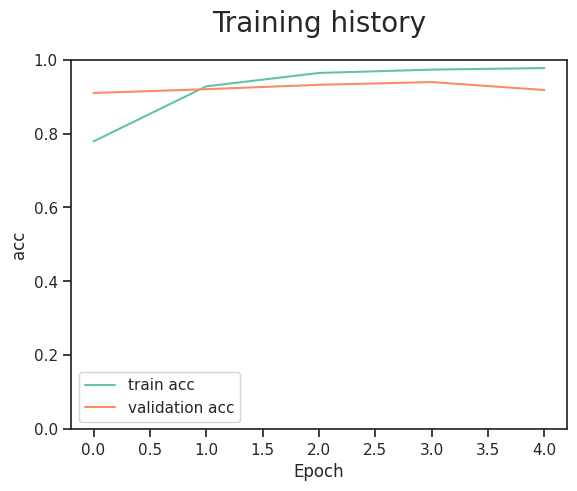

In [54]:
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')
plt.title('Training history')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [55]:
# Simpan Hasil Prediksi Validation Set
val_df = pd.read_csv(valid_dataset_path, sep='\t', names=['review_text', 'category'])
val_df['pred'] = list_hyp
val_df.head()
val_df.to_csv('val result.csv', index=False)

## f. Prediksi Test Set

In [56]:
# Prediksi test set
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
pred, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    pred += batch_hyp

  0%|          | 0/28 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 28/28 [00:04<00:00,  5.96it/s]


In [57]:
# Simpan prediksi test set
test_df = pd.read_csv(test_dataset_path, sep='\t', names=['review_text', 'category'])
test_df['pred'] = pred
test_df.head()
test_df.to_csv('test result.csv', index=False)

## g. Test fine-tuned model on sample sentences

In [58]:
text = 'aplikasi error'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: aplikasi error | Label : negative (96.999%)


In [59]:
text = 'aplikasi bagus dan membantu!'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: aplikasi bagus dan membantu! | Label : positive (99.498%)


In [68]:
text = 'pengirimannya lama banget'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: pengirimannya lama banget | Label : negative (95.214%)


# 9. Evaluasi

In [61]:
val_real = val_df.category
val_pred = val_df.pred

test_real = test_df.category
test_pred = test_df.pred

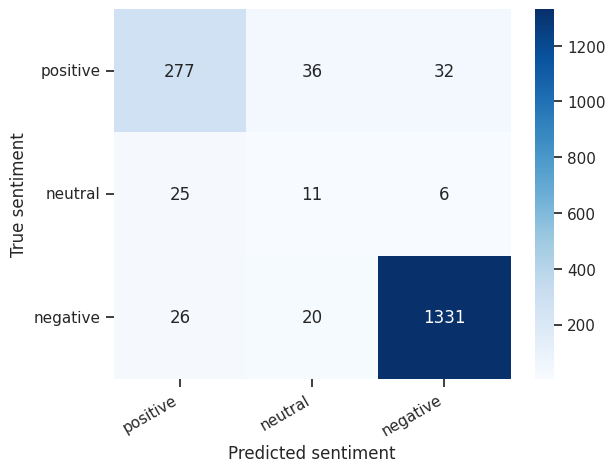

In [62]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(val_real, val_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [63]:
print(classification_report(val_real, val_pred, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.84      0.80      0.82       345
     neutral       0.16      0.26      0.20        42
    positive       0.97      0.97      0.97      1377

    accuracy                           0.92      1764
   macro avg       0.66      0.68      0.66      1764
weighted avg       0.93      0.92      0.92      1764



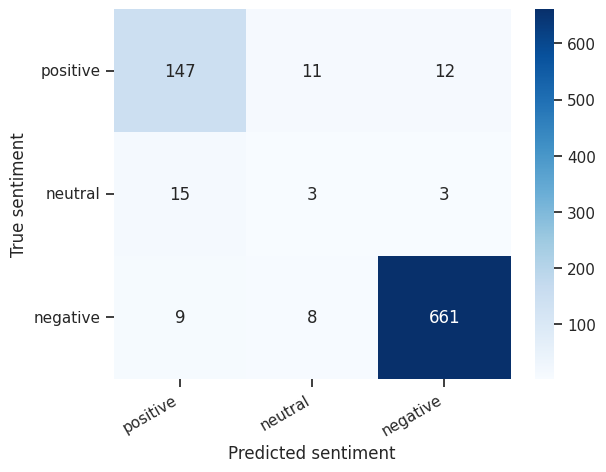

In [64]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(test_real, test_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [65]:
print(classification_report(test_real, test_pred, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.86      0.86      0.86       170
     neutral       0.14      0.14      0.14        21
    positive       0.98      0.97      0.98       678

    accuracy                           0.93       869
   macro avg       0.66      0.66      0.66       869
weighted avg       0.93      0.93      0.93       869

